# Evaluating semantic search vs hybrid search for retrieval

Using Ragas for evaluation: https://docs.ragas.io/en/latest/getstarted/index.html

In [ ]:
%pip install langchain_community
%pip install langchain_experimental
%pip install langchain-openai
%pip install langchainhub
%pip install chromadb
%pip install langchain
%pip install python-dotenv
%pip uninstall uvloop -y
%pip install PyPDF2 -q --user
%pip install rank_bm25

# new
%pip install ragas
%pip install tqdm -q --user
%pip install matplotlib

In [1]:
import os
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

## new
import tqdm as notebook_tqdm
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from ragas import evaluate
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

In [2]:
# variables
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddings()
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [3]:
# LLMs/Embeddings
embedding_ada = "text-embedding-ada-002"
model_gpt35="gpt-3.5-turbo"
model_gpt4="gpt-4o"

embedding_function = OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key)
llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
generator_llm = ChatOpenAI(model=model_gpt35, openai_api_key=openai.api_key, temperature=0.0)
critic_llm = ChatOpenAI(model=model_gpt4, openai_api_key=openai.api_key, temperature=0.0)

In [ ]:
#### INDEXING ####

In [4]:
# # Load the PDF and extract text
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [5]:
# Split
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [6]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [7]:
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [8]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [ ]:
#### RETRIEVAL and GENERATION ####

In [9]:
# Prompt
prompt = hub.pull("jclemens24/rag-prompt")

In [10]:
# Relevance check prompt
relevance_prompt_template = PromptTemplate.from_template(
    """
    Given the following question and retrieved context, determine if the context is relevant to the question.
    Provide a score from 1 to 5, where 1 is not at all relevant and 5 is highly relevant.
    Return ONLY the numeric score, without any additional text or explanation.

    Question: {question}
    Retrieved Context: {retrieved_context}

    Relevance Score:"""
)

In [11]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [12]:
def extract_score(llm_output):
    try:
        score = float(llm_output.strip())
        return score
    except ValueError:
        return 0

# Chain it all together with LangChain
def conditional_answer(x):
    relevance_score = extract_score(x['relevance_score'])
    if relevance_score < 4:
        return "I don't know."
    else:
        return x['answer']

In [13]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | RunnableParallel(
        {"relevance_score": (
            RunnablePassthrough()
            | (lambda x: relevance_prompt_template.format(question=x['question'], retrieved_context=x['context']))
            | llm
            | str_output_parser
        ), "answer": (
            RunnablePassthrough()
            | prompt
            | llm
            | str_output_parser
        )}
    )
    | RunnablePassthrough().assign(final_answer=conditional_answer)
)

In [14]:
rag_chain_similarity = RunnableParallel(
    {"context": dense_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [15]:
rag_chain_hybrid = RunnableParallel(
    {"context": ensemble_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [ ]:
# Question - Submitted to the similarity / dense vector search
result = rag_chain_similarity.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Similarity Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

In [ ]:
# Question - Submitted to the hybrid / multi-vector search
result = rag_chain_hybrid.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Dense Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

#### SIMILARITY SEARCH ONLY
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, water stewardship, and promoting a circular economy. They have implemented sustainability features in products like Google Maps, Google Nest thermostats, and Google Flights to help individuals make more sustainable choices. Google also supports various environmental organizations and initiatives, such as the iMasons Climate Accord, ReFED, and The Nature Conservancy, to accelerate climate action and address environmental challenges. Additionally, Google is involved in public policy advocacy and is committed to reducing its environmental impact through its operations and value chain.


#### HYBRID SEARCH

Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, promoting a circular economy, engaging with suppliers to reduce energy consumption and greenhouse gas emissions, and reporting environmental data. They also support public policy and advocacy for low-carbon economies, participate in initiatives like the iMasons Climate Accord and ReFED, and support projects with organizations like The Nature Conservancy. Additionally, Google is involved in initiatives with the World Business Council for Sustainable Development and the World Resources Institute to improve well-being for people and the planet. They are also working on using technology and platforms to organize information about the planet and make it actionable to help partners and customers create a positive impact.

### SYNTHETIC DATA GENERATION

In [16]:
# generator with openai models
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embedding_function
)

In [17]:
# Create a list of Document objects from the chunks
documents = [Document(page_content=chunk) for chunk in splits]

#### FOR FOLLOWING CODE: Uncomment and run once to generate source for test dataset! ####
# generate testset -
testset = generator.generate_with_langchain_docs(
    documents,
    test_size=10,
    distributions={
        simple: 0.5,
        reasoning: 0.25,
        multi_context: 0.25
    }
)

# comparison dataframe
testset_df = testset.to_pandas()

# save dataframes to CSV files in the specified directory
testset_df.to_csv(os.path.join('testset_data.csv'), index=False)

print("testset DataFrame saved successfully in the local directory.")

embedding nodes:   0%|          | 0/906 [00:00<?, ?it/s]

Generating:   0%|          | 0/10 [00:00<?, ?it/s]

testset DataFrame saved successfully in the local directory.


In [18]:
testset_df = testset.to_pandas()
len(testset_df)

# save dataframes to CSV files in the specified directory
testset_df.to_csv(os.path.join('testset_data.csv'), index=False)

print("testset DataFrame saved successfully in the local directory.")

testset DataFrame saved successfully in the local directory.


In [19]:
# pull data from saved testset, rather than generating above
### load dataframs from CSV file
saved_testset_df = pd.read_csv(os.path.join('testset_data.csv'))
print("testset DataFrame loaded successfully from local directory.")
saved_testset_df.head(5)

testset DataFrame loaded successfully from local directory.


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How does Google Flights provide carbon emissio...,"['When individuals search in Google Flights, t...",Google Flights provides carbon emissions estim...,simple,[{}],True
1,How is Google supporting the Nature Conservanc...,['iMasons Climate AccordGoogle is a founding m...,Google supported three of the Nature Conservan...,simple,[{}],True
2,How has Google demonstrated its support for st...,['We’ve consistently supported strong climate ...,Google has consistently supported strong clima...,simple,[{}],True
3,What innovative water stewardship solutions ar...,"['multiple offices around the world, we’ve ach...","The new Bay View campus, opened in 2022, is on...",simple,[{}],True
4,How much water have Google's contracted waters...,['In addition to focusing on responsible water...,271 million gallons of water,simple,[{}],True


### PREPARE SIMILARITY SEARCH DATASET

In [20]:
# Convert the DataFrame to a dictionary
saved_testing_data = saved_testset_df.astype(str).to_dict(orient='list')

# Create the testing_dataset
saved_testing_dataset = Dataset.from_dict(saved_testing_data)

# Update the testing_dataset to include only these columns -
# "question", "ground_truth", "answer", "contexts"
saved_testing_dataset_sm = saved_testing_dataset.remove_columns(["evolution_type", "episode_done"])

In [21]:
saved_testing_dataset_sm

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'metadata'],
    num_rows: 10
})

### EVAL SETS FOR EACH CHAIN

In [22]:
# Function to generate answers using the RAG chain
def generate_answer(question, ground_truth, rag_chain):
    result = rag_chain.invoke(question)
    return {
        "question": question,
        "answer": result["answer"]["final_answer"],
        "contexts": [doc.page_content for doc in result["context"]],
        "ground_truth": ground_truth
    }

In [23]:
# Add the "question", "answer", "contexts", and "ground_truth" to the testing_dataset
testing_dataset_similarity = saved_testing_dataset_sm.map(lambda x: generate_answer(x["question"], x["ground_truth"], rag_chain_similarity), remove_columns=saved_testing_dataset_sm.column_names)

Parameter 'function'=<function <lambda> at 0x79024cca2560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [24]:
# Add the "question", "answer", "contexts", and "ground_truth" to the testing_dataset
testing_dataset_hybrid = saved_testing_dataset_sm.map(lambda x: generate_answer(x["question"], x["ground_truth"], rag_chain_hybrid), remove_columns=saved_testing_dataset_sm.column_names)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

### EVAL SCORING

In [25]:
# similarity search score
score_similarity = evaluate(
    testing_dataset_similarity,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity
    ]
)
similarity_df = score_similarity.to_pandas()
similarity_df

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

,question,contexts,ground_truth,answer,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How does Google Flights provide carbon emissio...,"[When individuals search in Google Flights, th...",Google Flights provides carbon emissions estim...,Google Flights provides carbon emissions estim...,1.000000,0.958151,0.810714,1.0,0.591961,0.983229
1,How is Google supporting the Nature Conservanc...,[iMasons Climate AccordGoogle is a founding me...,Google supported three of the Nature Conservan...,Google is supporting the Nature Conservancy in...,1.000000,0.985615,1.000000,1.0,0.691318,0.965273
2,How has Google demonstrated its support for st...,[We’ve consistently supported strong climate p...,Google has consistently supported strong clima...,Google has demonstrated its support for strong...,1.000000,0.980116,1.000000,1.0,0.905077,0.953643
3,What innovative water stewardship solutions ar...,[Water stewardship\nTo help address local wate...,"The new Bay View campus, opened in 2022, is on...",Innovative water stewardship solutions being i...,1.000000,1.000000,0.883532,1.0,0.530168,0.920670
4,How much water have Google's contracted waters...,[In addition to focusing on responsible water ...,271 million gallons of water,"As of the end of 2022, Google's contracted wat...",1.000000,1.000000,0.870139,1.0,0.717243,0.868974
5,What percentage of emissions reductions by 205...,[Clean energy is also critical to reducing emi...,around 55%,Around 55% of the cumulative emissions reducti...,1.000000,0.985783,0.729167,1.0,0.209007,0.836028
6,What percentage of carbon-free energy do Googl...,"[United States Papillion, Nebraska PUE - - - -...",80%,Google data centers in Belgium get 80% of carb...,1.000000,1.000000,0.859259,1.0,0.201032,0.804127
7,How does Google support sustainable city proje...,[Global Covenant of Mayors for Climate & Energ...,Google supports sustainable city projects with...,Google supports sustainable city projects with...,1.000000,0.978086,0.937925,1.0,0.791604,0.984596
8,How do AI tools like Green Light and Environme...,[Jeff DeanChief ScientistGoogle DeepMind and \...,AI tools like Green Light and Environmental In...,AI tools like Green Light and Environmental In...,0.818182,0.978378,0.868707,1.0,0.635282,0.985574
9,What components are omitted from the weight ca...,"[electronic components and modules, optical co...","Printed circuit boards, labels, cables, connec...",The components omitted from the weight calcula...,1.000000,0.991897,0.875546,1.0,0.860257,0.970439


In [26]:
# similarity search score
score_hybrid = evaluate(
    testing_dataset_hybrid,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
        answer_similarity
    ]
)
hybrid_df = score_hybrid.to_pandas()
hybrid_df

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

,question,contexts,ground_truth,answer,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,How does Google Flights provide carbon emissio...,"[When individuals search in Google Flights, th...",Google Flights provides carbon emissions estim...,Google Flights provides carbon emissions estim...,0.800000,0.958186,0.744242,1.0,0.714221,0.981883
1,How is Google supporting the Nature Conservanc...,[iMasons Climate AccordGoogle is a founding me...,Google supported three of the Nature Conservan...,Google is supporting the Nature Conservancy in...,1.000000,0.978426,0.973933,1.0,0.691049,0.964195
2,How has Google demonstrated its support for st...,[We’ve consistently supported strong climate p...,Google has consistently supported strong clima...,Google has demonstrated its support for strong...,1.000000,0.950178,1.000000,1.0,0.767764,0.971057
3,What innovative water stewardship solutions ar...,"[multiple offices around the world, we’ve achi...","The new Bay View campus, opened in 2022, is on...","At the Bay View campus, innovative water stewa...",1.000000,0.999966,0.870115,1.0,0.328226,0.912932
4,How much water have Google's contracted waters...,[In addition to focusing on responsible water ...,271 million gallons of water,"As of the end of 2022, Google's contracted wat...",1.000000,0.987215,0.839001,1.0,0.717243,0.868974
5,What percentage of emissions reductions by 205...,[that Google can make a meaningful difference ...,around 55%,Around 55% of the cumulative emissions reducti...,1.000000,0.985783,0.682967,1.0,0.209019,0.836028
6,What percentage of carbon-free energy do Googl...,"[United States Papillion, Nebraska PUE - - - -...",80%,Google data centers in Belgium get 80% of carb...,1.000000,1.000000,0.876667,1.0,0.201029,0.804127
7,How does Google support sustainable city proje...,[Global Covenant of Mayors for Climate & Energ...,Google supports sustainable city projects with...,Google supports sustainable city projects with...,1.000000,0.988952,0.953604,1.0,0.808532,0.984234
8,How do AI tools like Green Light and Environme...,[Jeff DeanChief ScientistGoogle DeepMind and \...,AI tools like Green Light and Environmental In...,AI tools like Green Light and Environmental In...,0.777778,0.978382,0.842753,1.0,0.794134,0.994718
9,What components are omitted from the weight ca...,"[electronic components and modules, optical co...","Printed circuit boards, labels, cables, connec...",The components omitted from the weight calcula...,1.000000,0.991873,0.931796,1.0,0.860410,0.971076


### ANALYSIS

In [27]:
# Analysis that consolidates everything into easier to read scores
# key columns to compare
key_columns = [
    'faithfulness',
    'answer_relevancy',
    'context_precision',
    'context_recall',
    'answer_correctness',
    'answer_similarity'
]

# mean scores for each key column in similarity_df
similarity_means = similarity_df[key_columns].mean()

# mean scores for each key column in hybrid_df
hybrid_means = hybrid_df[key_columns].mean()

# comparison dataframe
comparison_df = pd.DataFrame({'Similarity Run': similarity_means, 'Hybrid Run': hybrid_means})

# difference between the means
comparison_df['Difference'] = comparison_df['Similarity Run'] - comparison_df['Hybrid Run']

# save dataframes to CSV files in the specified directory
similarity_df.to_csv(os.path.join('similarity_run_data.csv'), index=False)
hybrid_df.to_csv(os.path.join('hybrid_run_data.csv'), index=False)
comparison_df.to_csv(os.path.join('comparison_data.csv'), index=True)

print("Dataframes saved successfully in the local directory.")

Dataframes saved successfully in the local directory.


In [28]:
### load dataframes from CSV files
sem_df = pd.read_csv(os.path.join('similarity_run_data.csv'))
rec_df = pd.read_csv(os.path.join('hybrid_run_data.csv'))
comparison_df = pd.read_csv(os.path.join('comparison_data.csv'), index_col=0)

print("Dataframes loaded successfully from the local directory.")

# Analysis that consolidates everything into easier to read scores
print("Performance Comparison:")
print("\n**Retrieval**:")
print(comparison_df.loc[['context_precision', 'context_recall']])
print("\n**Generation**:")
print(comparison_df.loc[['faithfulness', 'answer_relevancy']])
print("\n**End-to-end evaluation**:")
print(comparison_df.loc[['answer_correctness', 'answer_similarity']])

Dataframes loaded successfully from the local directory.
Performance Comparison:

**Retrieval**:
                   Similarity Run  Hybrid Run  Difference
context_precision        0.883499    0.871508    0.011991
context_recall           1.000000    1.000000    0.000000

**Generation**:
                  Similarity Run  Hybrid Run  Difference
faithfulness            0.981818    0.957778    0.024040
answer_relevancy        0.985803    0.981896    0.003906

**End-to-end evaluation**:
                    Similarity Run  Hybrid Run  Difference
answer_correctness        0.613295    0.609163    0.004132
answer_similarity         0.927255    0.928922   -0.001667


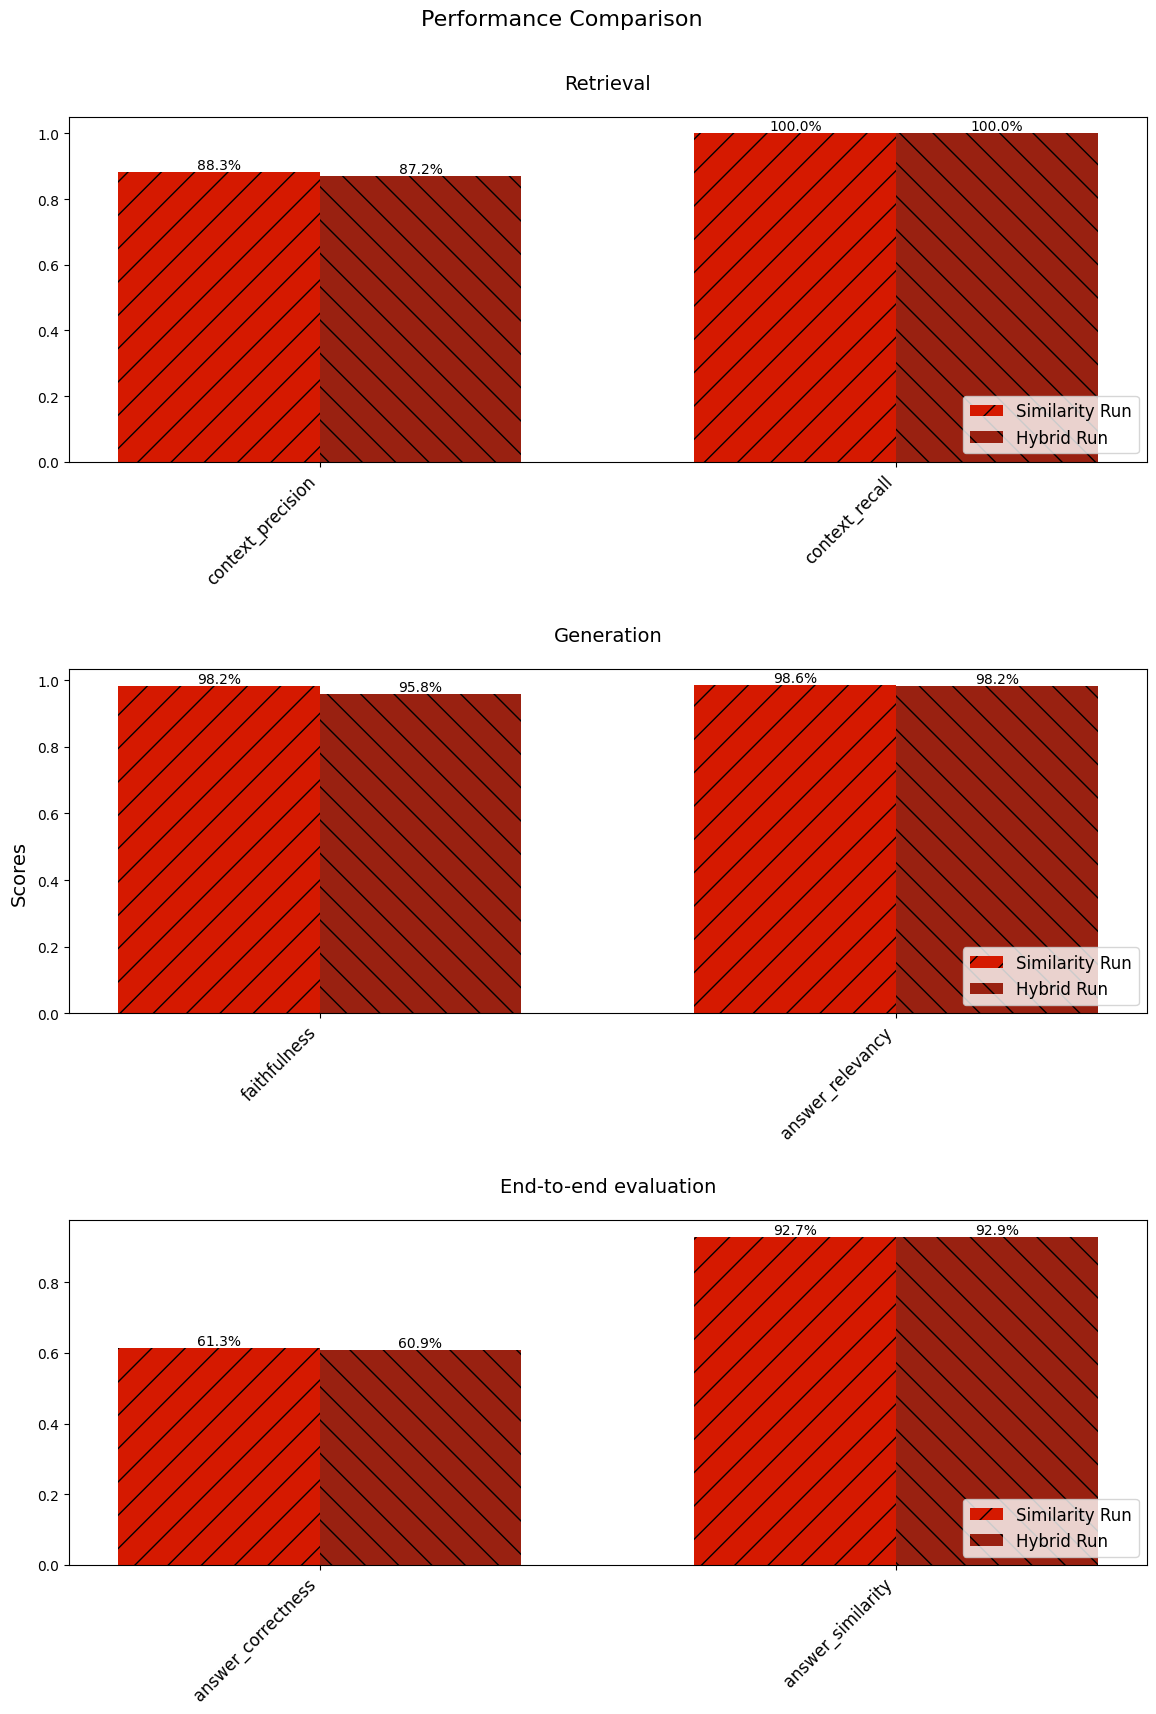

In [29]:
# plotting - create subplots for each category with increased spacing
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)
bar_width = 0.35
categories = ['Retrieval', 'Generation', 'End-to-end evaluation']
metrics = [
    ['context_precision', 'context_recall'],
    ['faithfulness', 'answer_relevancy'],
    ['answer_correctness', 'answer_similarity']
]

# iterate over each category and plot the corresponding metrics
for i, (category, metric_list) in enumerate(zip(categories, metrics)):
    ax = axes[i]
    x = range(len(metric_list))

    # plot bars for Similarity Run (hex color #D51900)
    similarity_bars = ax.bar(x, comparison_df.loc[metric_list, 'Similarity Run'], width=bar_width, label='Similarity Run', color='#D51900', hatch='/')

    # add values to Similarity Run bars
    for bar in similarity_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    # plot bars for Hybrid Run (hex color #992111)
    hybrid_bars = ax.bar([i + bar_width for i in x], comparison_df.loc[metric_list, 'Hybrid Run'], width=bar_width, label='Hybrid Run', color='#992111', hatch='\\')

    # add values to Hybrid Run bars
    for bar in hybrid_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    ax.set_title(category, fontsize=14, pad=20)
    ax.set_xticks([i + bar_width / 2 for i in x])
    ax.set_xticklabels(metric_list, rotation=45, ha='right', fontsize=12)

    # move the legend to the bottom right corner
    ax.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 0))

# add overall labels and title
fig.text(0.04, 0.5, 'Scores', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Performance Comparison', fontsize=16)

# adjust spacing between subplots and increase the top margin
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.6, top=0.92)
plt.show()